# 部分決定係数（partial R2）

Partial $R^2$ （偏決定係数、部分決定係数、偏重相関 などと呼ばれる）は Rosenbaum (2002) の改良として Imbens (2003)が提案した、未観測の交絡因子の強さを把握する手法。


結果$Y$、処置$T$、未観測の交絡因子$U$それぞれに分布型を仮定してパラメトリックモデルを構築する。

### 1. 未観測の交絡因子$U$のモデル

未観測の交絡因子$U$は確率0.5のベルヌーイ分布に従うとする。つまり未観測の交絡因子が影響する/しないの値${1,0}$が$1/2$の確率で決まるとする。

$$
U_i \stackrel{\text { ind }}{\sim} \operatorname{Bern} \left(\frac{1}{2} \right)
$$

### 2. 処置変数$T$のモデル

処置$T$は二値変数で、ロジスティック回帰モデルで表現できると仮定する。観測済みの共変量$X$だけでなく、未観測の交絡$U$も影響するとして、処置$T$へ$\alpha$倍の強さで影響すると仮定する。

$$
T_i \mid X_i, U_i \stackrel{\text { ind }}{\sim} \operatorname{Bern}\left(\operatorname{sigmoid}\left(\gamma X_i+\alpha U_i\right)\right)
$$

別の書き方をすれば

$$
P(T_i = 1 \mid X_i, U_i) = \frac{ 1 }{ 1 + \exp( -(\gamma X_i + \alpha U_i) )}
$$

### 3. 結果変数$Y$のモデル

結果$Y$と他の変数との関係には正規線形回帰モデルを仮定する。未観測の交絡$U$は結果$Y$へ$\delta$倍の強さで影響すると仮定する。

$$
Y_i \mid X_i, T_i, U_i \stackrel{\text { ind }}{\sim} \mathcal{N}\left(\tau T_i+\beta X_i+\delta U_i, \sigma^2\right)
$$

別の書き方をすれば

$$
Y_i = \tau T_i + \beta X_i + \delta U_i + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2)
$$

となる。


### 考え方

$U$は未観測だが、$\alpha, \delta$をなんらかの値に固定すれば、他のパラメータは最尤推定できる。したがって、$\alpha, \delta$をさまざまな値に変えたもとでの推定を行うことで、

1. 未観測の交絡因子が割当や結果変数にどれくらい影響力があるか
2. 因果効果の推定値$\tau$がどの程度変化するか

を推定することができる

### 部分決定係数

:::{admonition} 部分決定係数

$Y$の部分決定係数$R^2_{Y, par}(\alpha, \delta)$は次のように定義される

$$
R^2_{Y, par}(\alpha, \delta)
= 1 - \frac{ \text{RSS}_{\text{full}} }{ \text{RSS}_{\text{reduced}} }
$$

- $\text{RSS}_{\text{full}}$：$U$を含むモデルの残差平方和
- $\text{RSS}_{\text{reduced}}$：$U$を含まない、観測した変数のみのモデルの残差平方和

:::

直感的な解釈としては「$U$を追加したことで説明できた部分がどれだけあるか」。$U$を追加して$\text{full}$モデルの説明力が$\text{reduced}$モデルより高くなれば、 $\text{RSS}_{\text{full}} < \text{RSS}_{\text{reduced}}$ になる。

なので、

- 未観測の交絡因子$U$の影響が **多い** 場合、$\text{RSS}_{\text{full}} < \text{RSS}_{\text{reduced}}$になり$R^2_{Y, par}(\alpha, \delta)$は **1に近づく**
- 未観測の交絡因子$U$の影響が **少ない** 場合、$\text{RSS}_{\text{full}} \approx \text{RSS}_{\text{reduced}}$になり$R^2_{Y, par}(\alpha, \delta)$は **0に近づく** 

ということになる。

→ ⚠️通常の決定係数は1に近いほどいいが、 **部分決定係数は0に近いほどよい** ことになる点に注意。


### 実装

PySensemakrパッケージが便利。

:::{card}
[PySensemakr: Sensitivity Analysis Tools for Regression Models in Python](https://pysensemakr.readthedocs.io/en/latest/)
:::

In [4]:
!pip install -U PySensemakr


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import sensemakr as smkr
import statsmodels.formula.api as smf

# loads data
darfur = smkr.load_darfur()
# runs regression model
reg_model = smf.ols(formula='peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + '\
                    'pastvoted + hhsize_darfur + female + village', data=darfur)
darfur_model = reg_model.fit()

# Create a sensemakr object and print summary of results
darfur_sense = smkr.Sensemakr(model = darfur_model,
                              treatment = "directlyharmed",
                              benchmark_covariates = ["female"],
                              kd = [1,2,3])
darfur_sense.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustness Valu

/usr/local/lib/python3.10/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float
/usr/local/lib/python3.10/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float


### 結果の読み方

> Sensitivity Statistics

の箇所に部分決定係数が表示されている

```
Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 
```


- `Partial R2 of treatment with outcome`：部分決定係数
- `Robustness Value, q = 1`： **Robustness Value** は未観測の交絡因子が処置変数と結果変数に与える影響を定量的に測る指標。値が大きいほど影響を受けないことを示す。
    - 例えばRobustness Valueが0.1なら、処置変数と結果変数の両方の残差の分散のうち10%を説明するほどの未観測の交絡因子が存在しない限り、処置の結果への影響はロバストであるという意味。
- `Robustness Value, q = 1 alpha = 0.05`：統計的有意性も加味したもの。

AttributeError: 'QuadContourSet' object has no attribute 'collections'

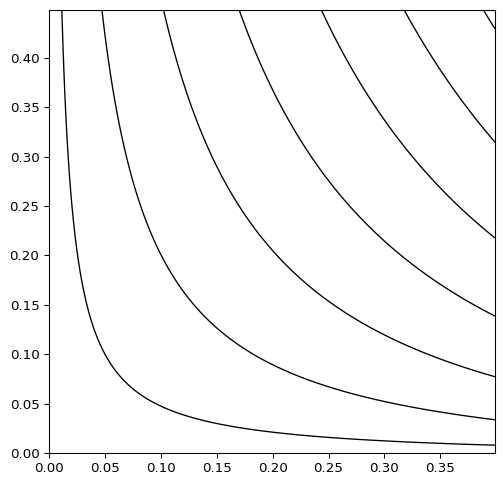

In [6]:
# contour plot for the estimate
# x軸が処置変数の部分決定係数
# y軸が結果変数の部分決定係数
darfur_sense.plot()

In [ ]:
# extreme scenarios plot
darfur_sense.plot(plot_type = 'extreme')

## 参考文献

- [Imbens, G. W. (2003). Sensitivity to exogeneity assumptions in program evaluation. American Economic Review, 93(2), 126-132.](https://scholar.harvard.edu/imbens/files/sensitivity_to_exogeneity_assumptions_in_program_evaluation.pdf)
- 星野崇宏. (2009). 調査観察データの統計科学: 因果推論・選択バイアス・データ融合.

